## Integrating Planning into RL methods via Dyna
### BlackJack

- Aaron Dharna

In [1]:
from collections import defaultdict
from collections import namedtuple
import numpy as np
import sys
import gym

In [2]:
from plot_utils import plot_blackjack_values
from plot_utils import plot_policy
import matplotlib.pyplot as plt

In [3]:
env = gym.make('Blackjack-v0')

Each state is a 3-tuple of:
- the player's current sum $\in \{0, 1, \ldots, 31\}$,
- the dealer's face up card $\in \{1, \ldots, 10\}$, and
- whether or not the player has a usable ace (`no` $=0$, `yes` $=1$).

The agent has two potential actions:

```
    STICK = 0
    HIT = 1
```

In [4]:
#Helper functions for Q learning.

def e_greedy_policy_creation(Qstate, epsilon, nA):
    """
    Q: Our Q table. 
      Q[state] = numpy.array
      Q[state][action] = float.
    epsilon: small value that controls exploration.
    nA: the number of actions available in this environment
    
    return: an epsilon-greedy policy specific to the state.
    """
    
    policy = np.ones(nA) * epsilon/nA
    policy[np.argmax(Qstate)] = 1 - epsilon + (epsilon / nA)        
    return policy

In [5]:
def choose_action(policy, env):
    return np.random.choice(np.arange(env.action_space.n), p=policy)

> In this chapter we develop a unified view of reinforcement learning methods that require a model of the environment, such as dynamic programming and heuristic search, and methods that can be used without a model, such as Monte Carlo and temporal-difference methods. These are respectively called model-based and model-free reinforcement learning methods. Model-based methods rely on planning as their primary component, while model-free methods primarily rely on learning.

# Dyna: Integrated Planning, Acting, and Learning


Given a state and an action, a `model`, M, produces a prediction of the resultant next state and next reward. The model-learning method is also table-based and assumes the environment is deterministic. After each transition $S_t, A_t \rightarrow R_{t+1}, S_{t+1}$,the model records in its table entry for $S_t$, $A_t$ the prediction that $R_{t+1},S_{t+1}$ will deterministically follow. Thus, if the model is queried with a state–action pair that has been experienced before, it simply returns the last-observed next state and next reward as its prediction.

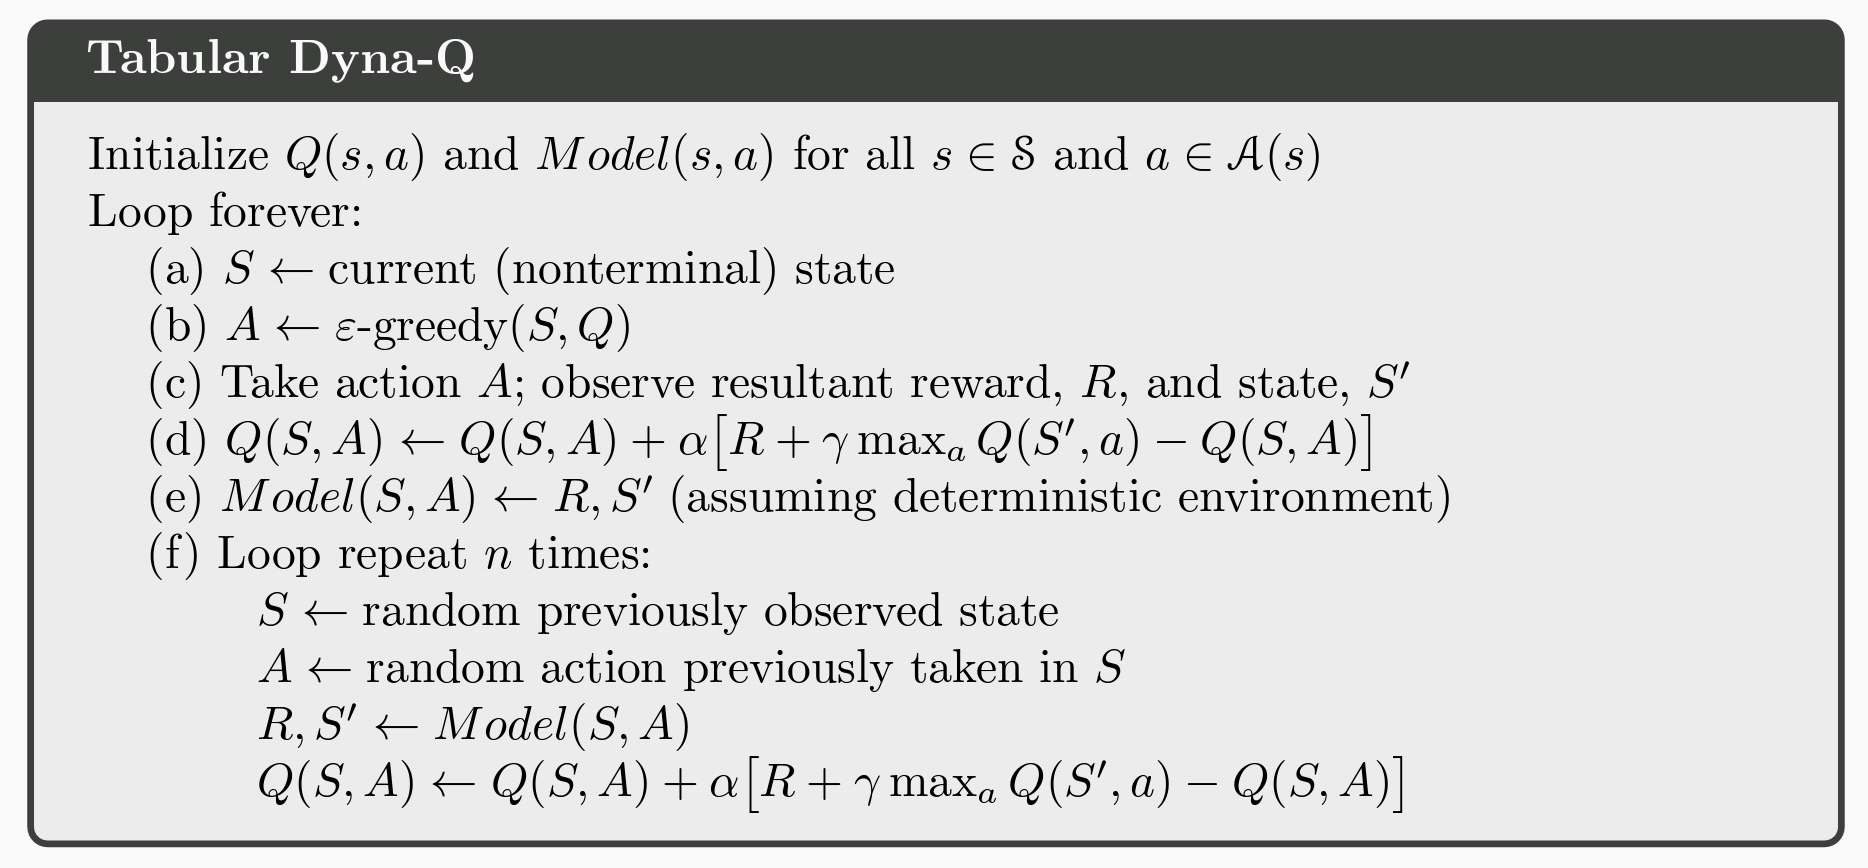

----

`tPlusOne` is simply a namedtuple so that we can easily store resultant states and rewards for our model.

In [6]:
tPlusOne = namedtuple('prediction', ['next_state', 'reward'])

# TabularDynaQ

- `env` openAi blackjack env 
- `depth` planning parameter
- `num_episodes` number of games of blackjack to play
- `alpha` step-size paramater for Q learning
- `gamma` future-reward discount parameter


In [7]:
def tabularDynaQ(env, depth, num_episodes, alpha, gamma=1):
    nA = env.action_space.n
    # initialize action-value function (empty dictionary of arrays)    
    Q = defaultdict(lambda: np.zeros(nA))
    # initialize model of env
    M = defaultdict(lambda: tPlusOne('s', 'r'))
    for i_episode in range(1, num_episodes+1):     
        
        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush() 
        
        state = env.reset()
        epsilon = 0.1

        while True:

            policy = e_greedy_policy_creation(Q[state], epsilon, nA)
            action = choose_action(policy, env)
            sPrime, reward, done, info = env.step(action)
            policy = e_greedy_policy_creation(Q[sPrime], epsilon, nA)
            Q[state][action] += alpha * (reward + (gamma * np.max(Q[sPrime])) - Q[state][action])
            M[(state, action)] = tPlusOne(sPrime, reward)
            state = sPrime

            for _ in range(depth):
                index = np.random.choice(range(len(M.keys())))
                hand, act = list(M.keys())[index]
                sP, reward = M[(hand, act)]
                Q[hand][act] += alpha * (reward + (gamma * np.max(Q[sP])) - Q[hand][act])

            if done:
                break
    return Q, M

## Our visualization function will take in: 

- `depth` for how long do we want to plan?
- `num_episodes` how many games of blackjack do we want to play?
- `alpha` step-size parameter
- `gamma` decay factor

The function will display three plots: 
    - value when holding an ace of a given hand
    - value when not holding as ace of a given hand
    - the derived policy

In [8]:
def runAndVisualizeDynaQ(depth, num_episodes, alpha, gamma):
    Q_dyna, model = tabularDynaQ(env, depth, num_episodes, alpha, gamma)

    # obtain the state-value function
    V_Dyna = dict((k,np.max(v)) for k, v in Q_dyna.items())

    # plot the state-value function
    plot_blackjack_values(V_Dyna)

    policy = dict((k,np.argmax(v)) for k, v in Q_dyna.items())

    plot_policy(policy)

----

----

# The Optimal Solution for Blackjack from S&B:

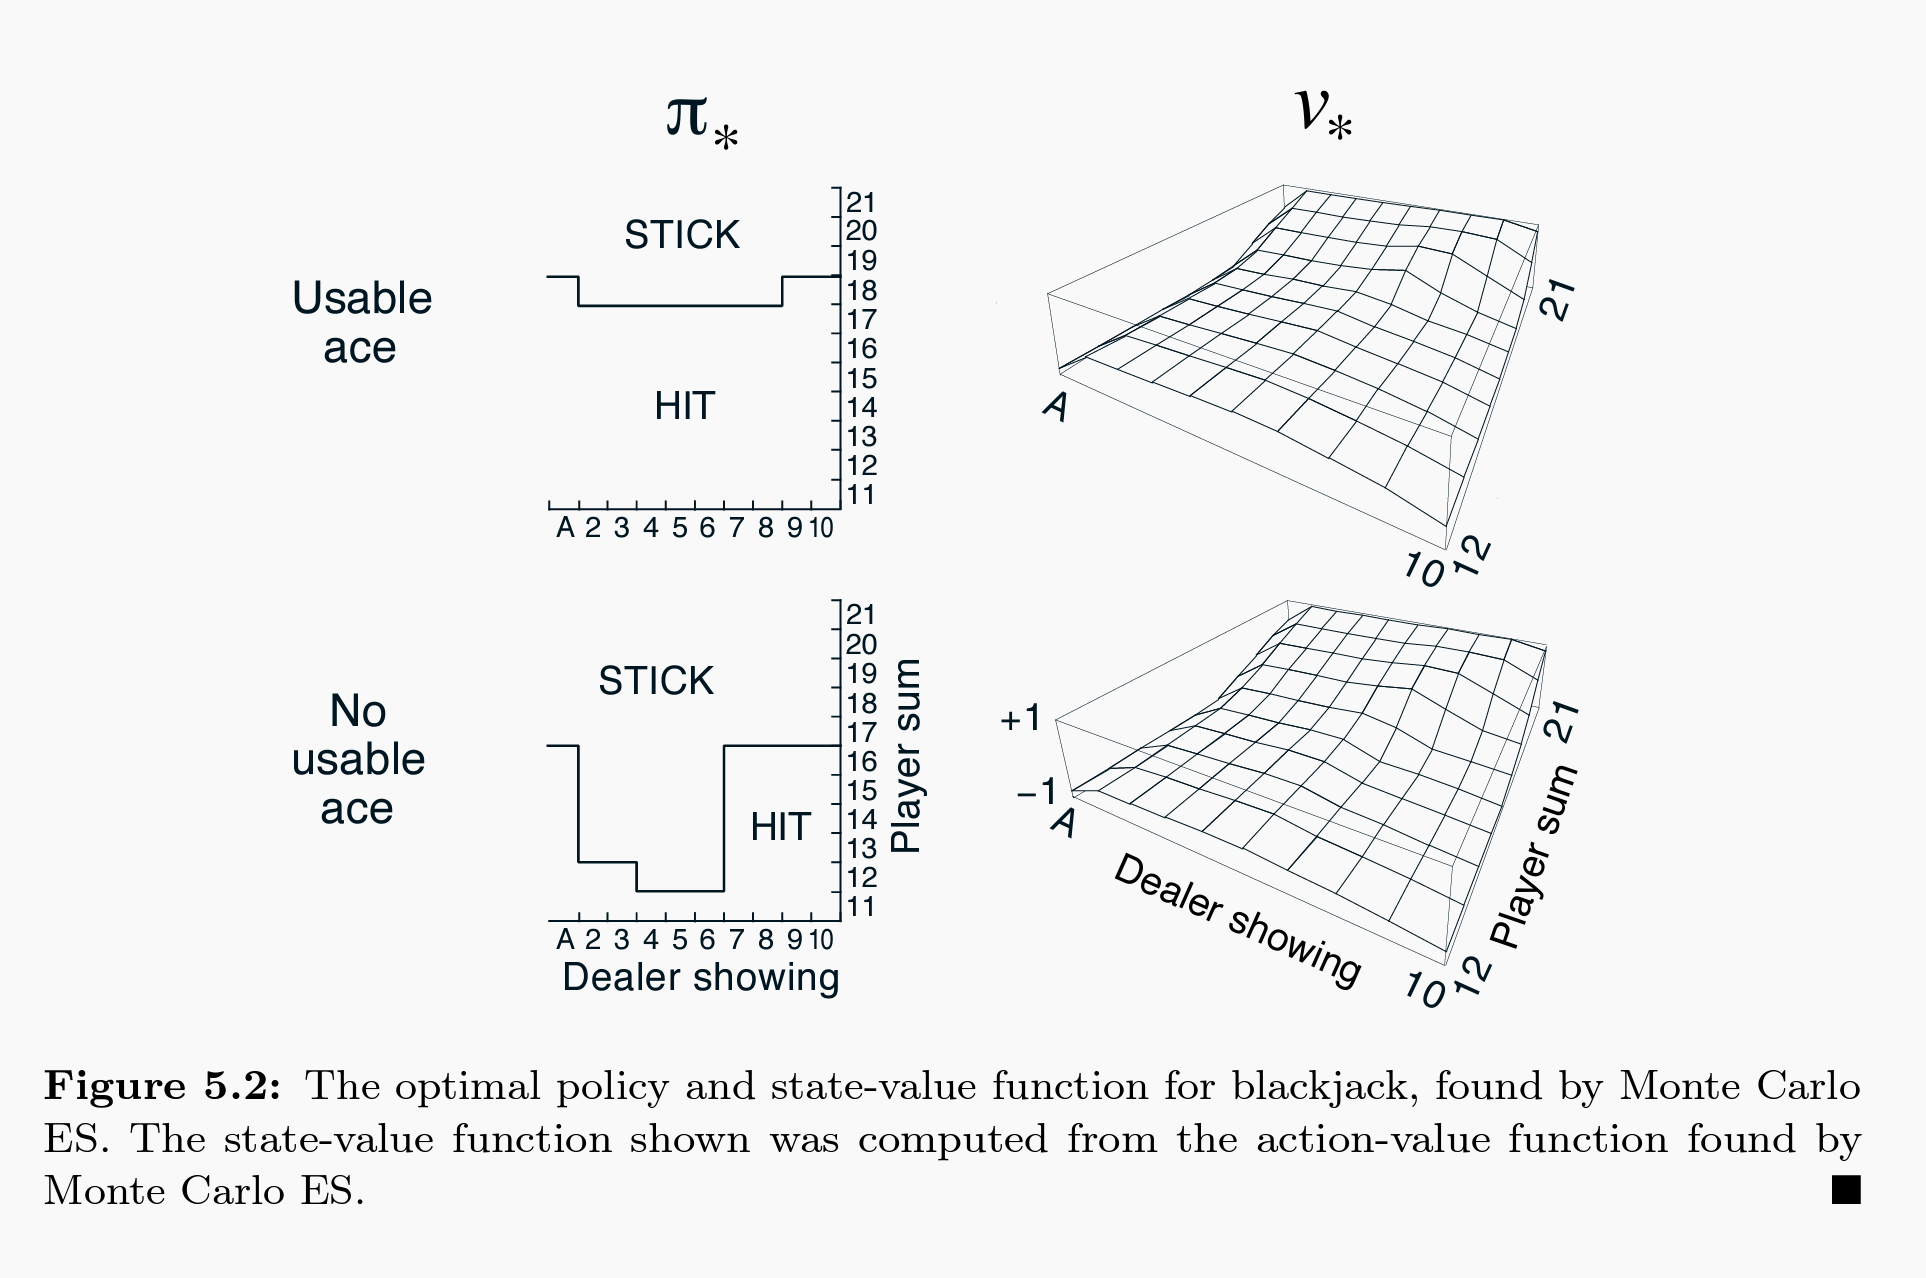

----

----

# Testing DynaQ

----

First up, is regular Q-learning. We're giving this one a really long episode count since this will only be able to udpate once cell per episode. Ideally, this will converge to the optimal solution (and it just about does).

Episode 500000/500000

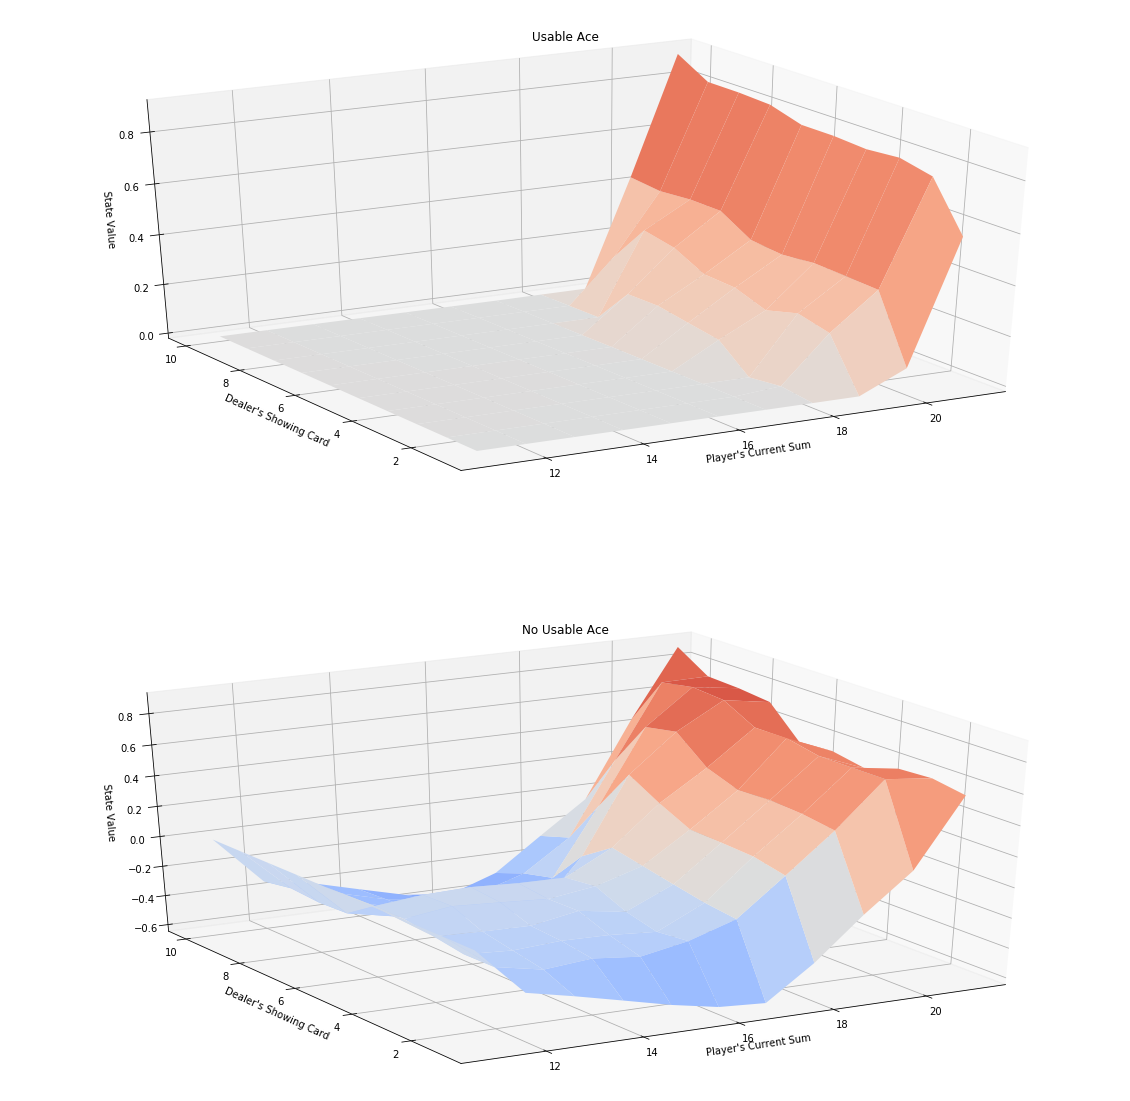

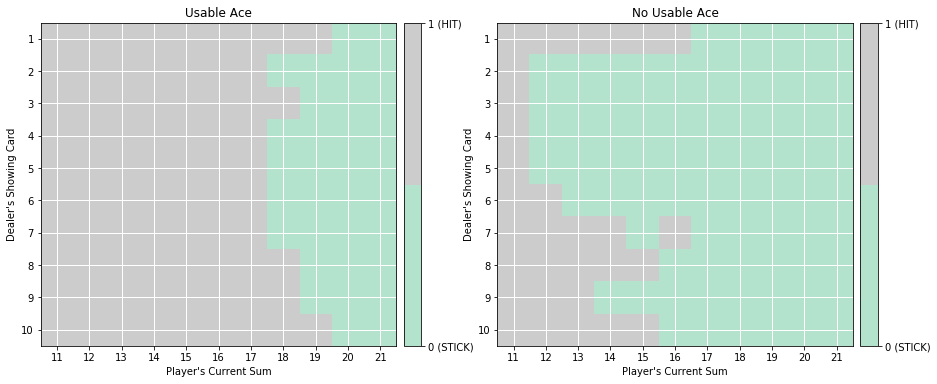

In [9]:
runAndVisualizeDynaQ(0, 500000, .001, 0.01)

While this is not quite optimal, it is very close. A longer episode length would probably make it match exactly. 

----

Now, what if we introduce planning? The experiment that seems the most natrual to start is: what if we have a few planning steps, say 10, and bring down our episodes down, say 100000?

Episode 100000/100000

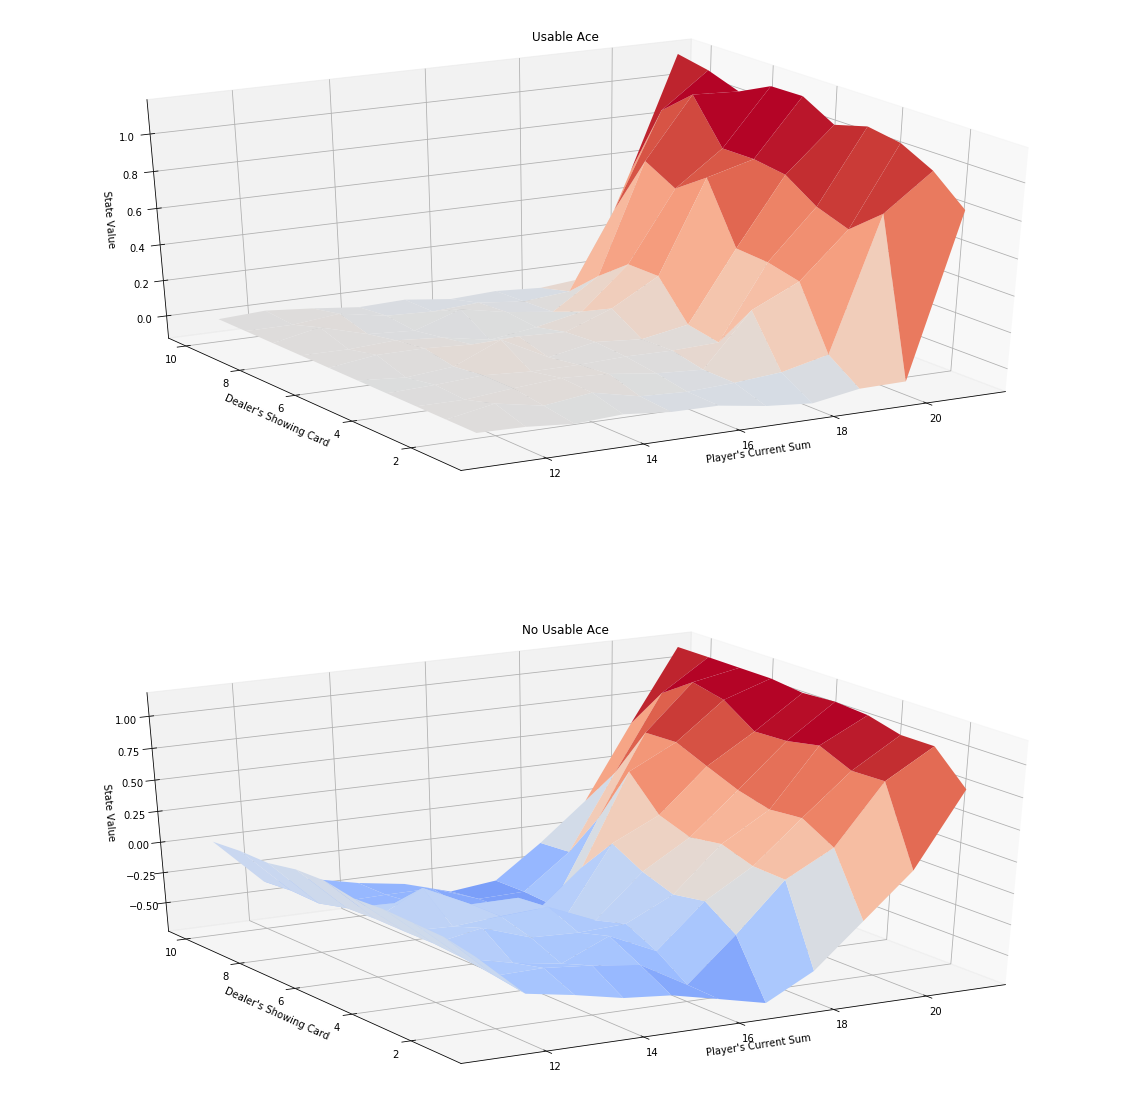

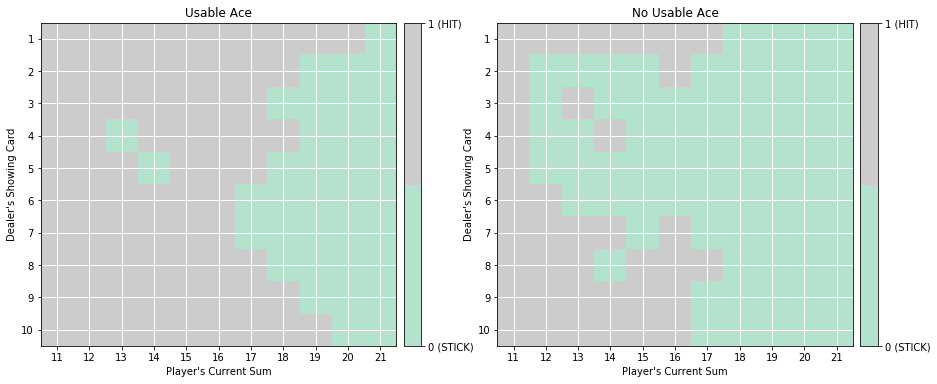

In [10]:
runAndVisualizeDynaQ(10, 100000, .001, 0.25)

This is close! So, lets try increasing depth and decreasing episodes even further!

----

Episode 25000/25000

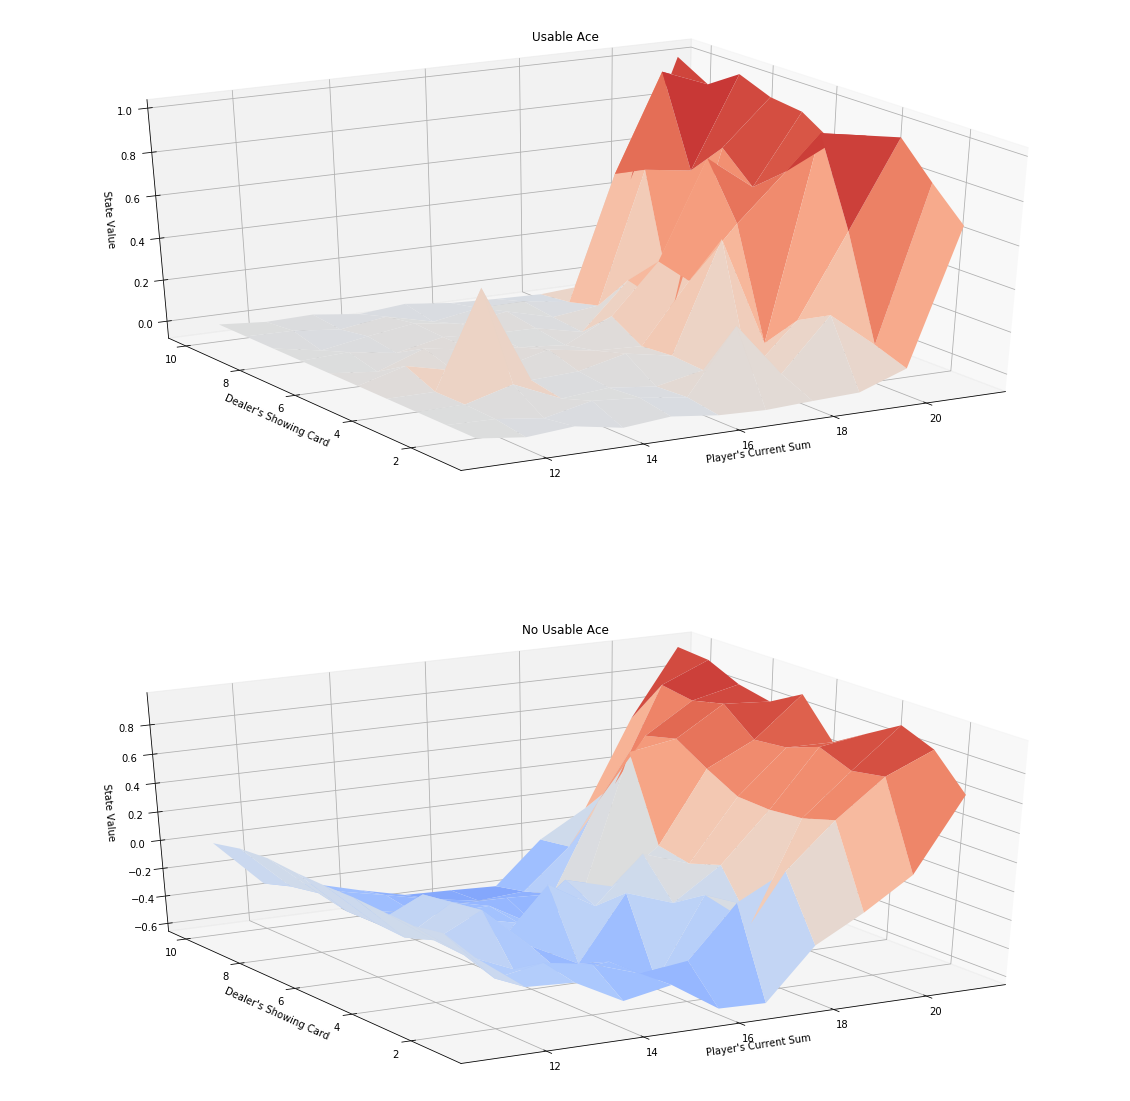

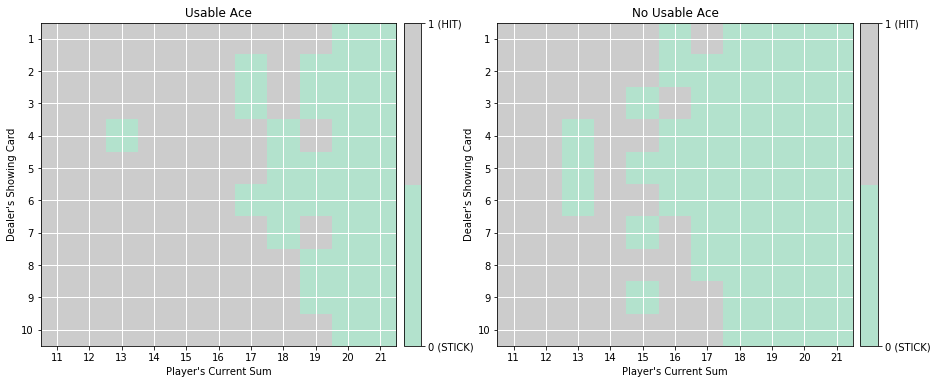

In [11]:
runAndVisualizeDynaQ(25, 25000, .001, 0.25)

If we look at the value-function plot, we're clearly losing clarity here; however, let's drastically increasing the planning parameter and decrease the episode lengths further. 

----

Episode 15000/15000

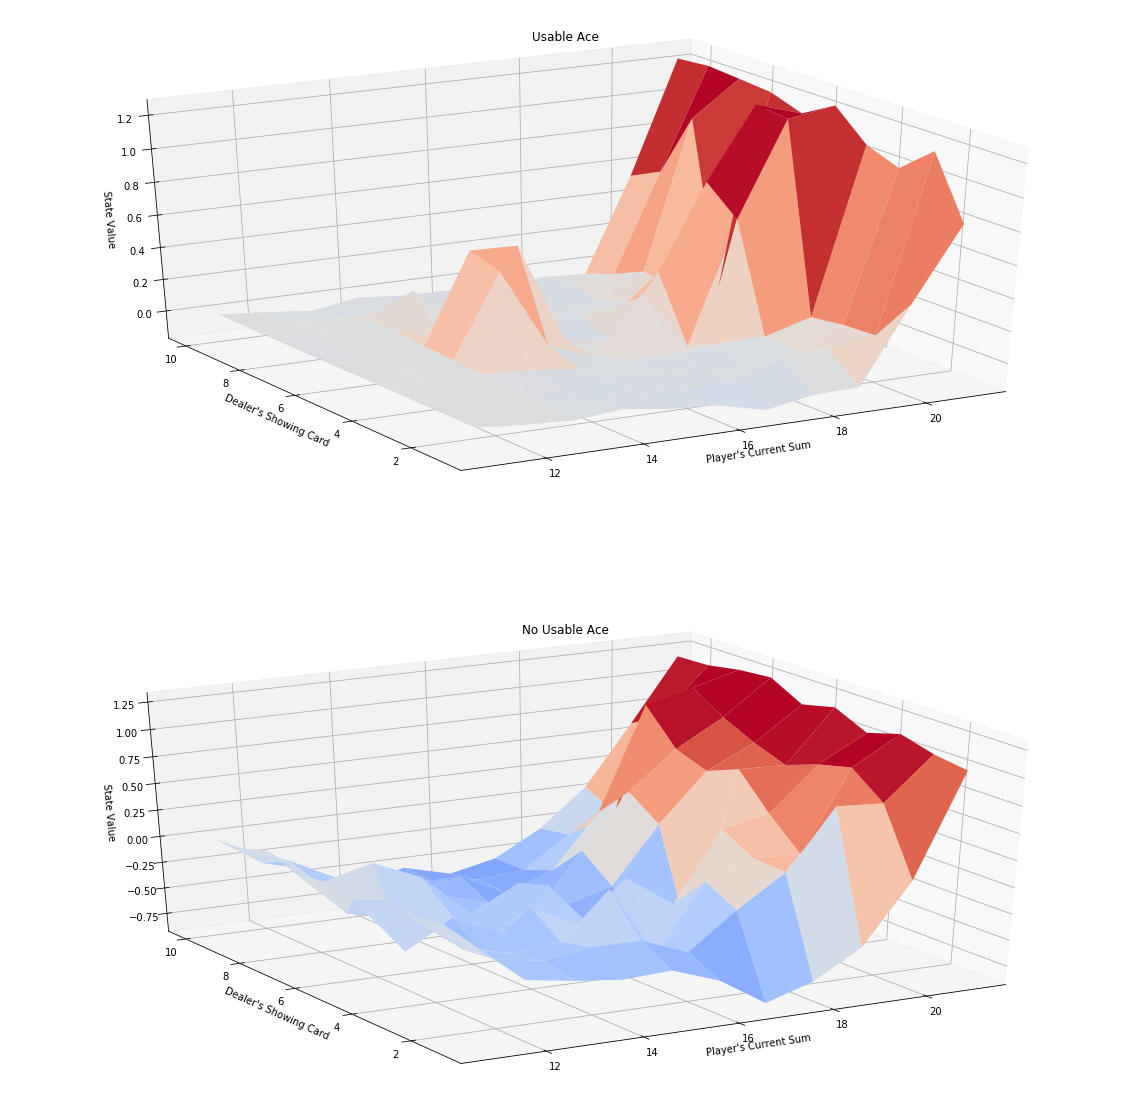

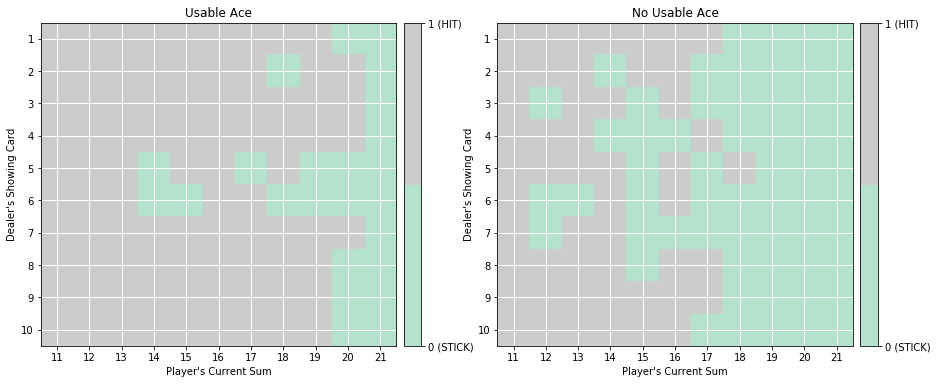

In [12]:
runAndVisualizeDynaQ(100, 15000, .001, 0.25)

Since it seems that we've pushed the planning too far, I'm going to go back to `runAndVisualizeDynaQ(25, 25000, .001, 0.01)` and increase the number of episodes. 10 and 100000 did pretty well as depth and episodes, therefore, let's match the episode count and increase the planning.  

Episode 100000/100000

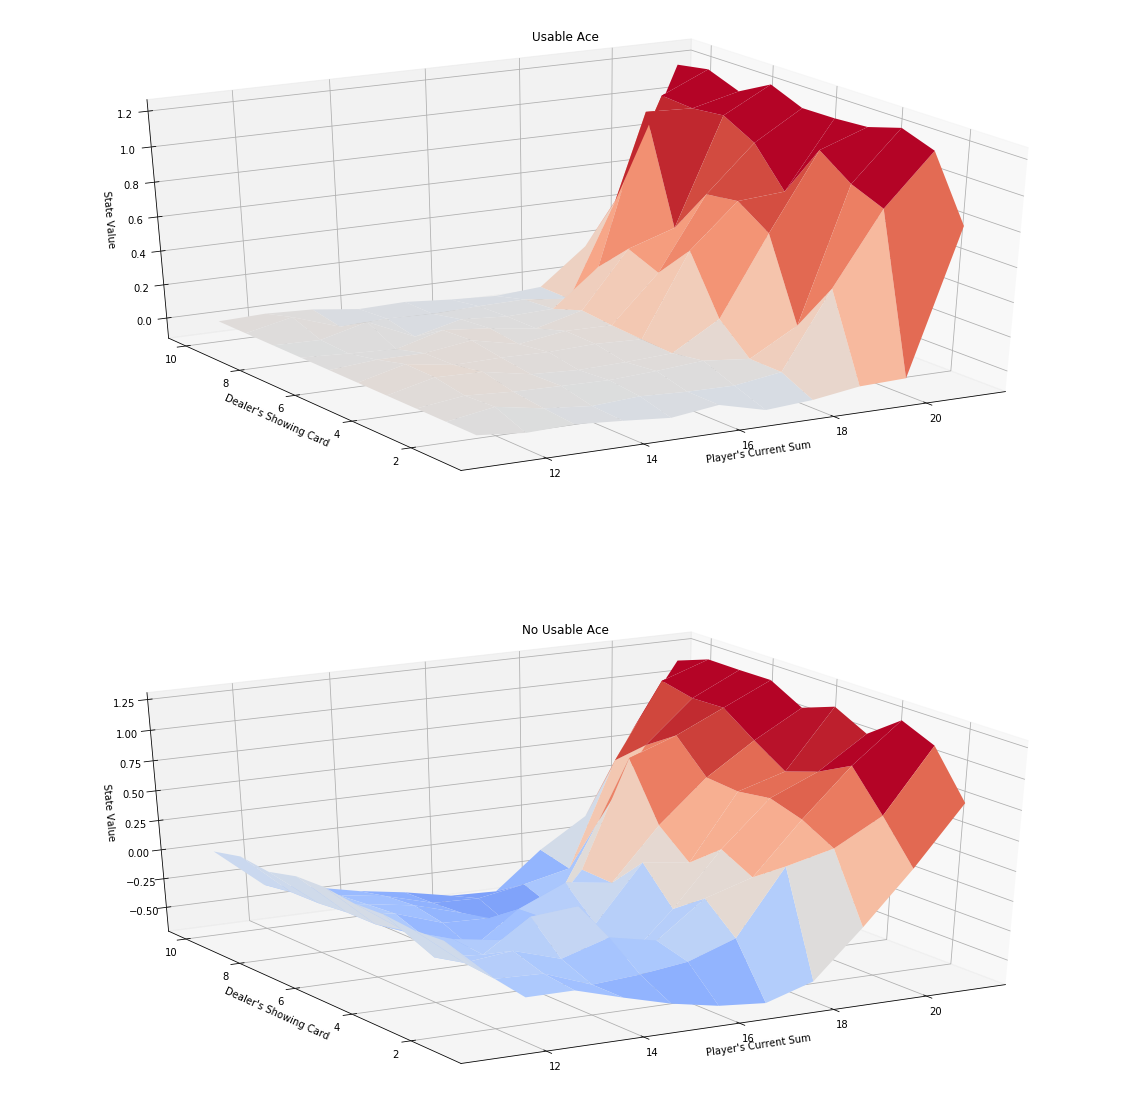

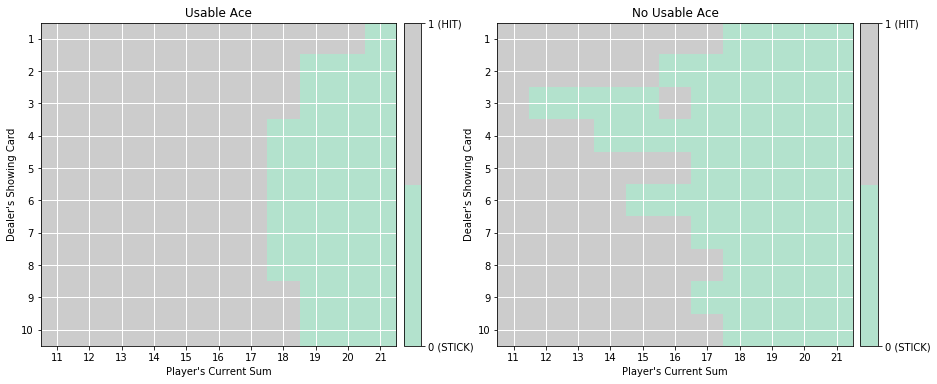

In [13]:
runAndVisualizeDynaQ(25, 100000, .001, 0.25)

One reason that we could be doing a poor job of converging onto Q-learning's answer is because our model -- $S_t, A_t \rightarrow R_{t+1}, S_{t+1}$, -- is inherently kinda bad. If we wanted to imporve our model we could instead capture a probability that we go bust from that position. But then we've kind of infringed upon what the value function is supposed to be doing. 

----

----

# Moving forward to Monte-Carlo Tree Search.